# Courtney's SSP Guide Notebook on WiFeS spectra

In [1]:
## import section, these are packages that I use in every code
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# we probably wont use this but I have it in every notebook just in case
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
## this package is used to open and read fits files, you'll need to install astropy for it
from astropy.io import fits
## this package helps with dealing with your file structures
import os

In [2]:
## "magic" command for setting the jupyter backend
## allows you to have plots show inline in notebooks
%matplotlib inline

In [3]:
# #this is a style file that I use for all of my plots, I can give it to you if you like
## alternatively, search "rcParams" in the matplotlib documentation
plt.style.use('court.mplstyle')

In [4]:
## alright let's pick a fits file to load in, yours will be in a different file path
## remember to change the path
spectrum = fits.open('../2023_spectra/reduced/Obs-13040-1x2-Full-ASAS-RCB-4/OBK-417280-WiFeS-Red--UT20230618T125808-2.fits')


In [5]:
## we can look at the structure of this fits file
## note that if you were not in a notebook, or if you weren't at the last line of a notebook cell
##   that you'd need to put this inside a print() statement
# print(spectrum.info())
spectrum.info()

Filename: ../2023_spectra/reduced/Obs-13040-1x2-Full-ASAS-RCB-4/OBK-417280-WiFeS-Red--UT20230618T125808-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (25, 38, 3404)   float64   
  1                1 ImageHDU        97   (25, 38, 3404)   float64   
  2                1 ImageHDU        97   (25, 38, 3404)   float64   


In [6]:
## we can also look at the header for this 
## [0] indicates that we're looking at the first extension of the file 
## that's USUALLY where all the data is
spectrum[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   25                                                  
NAXIS2  =                   38                                                  
NAXIS3  =                 3404                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSBLKID=               417280 / Observation Block ID                           
PROPID  =              2360129 / Proposal ID                                    
FOCUSR  =                   -2 / WiFeS Red Camera focus (station)               
FOCUSB  =                   

In [7]:
## We can access any one of these values by calling its name
spectrum[0].header['CRVAL3']

5300.0

In [8]:
## now our data structure is a bit weird. That's because WiFeS is an integral field spectrograph
## The data lives in an extension called "data"
## lets look at the dimensions of that extension
np.shape(spectrum[0].data)

(3404, 38, 25)

In [9]:
## so this is actually a data "cube" in that it has 3 dimensions.
## dimension 1 (or zero in python indexing) corresponds to the wavelength (in "pixels")
## so "pixel" 0 has this shape
np.shape(spectrum[0].data[0])

(38, 25)

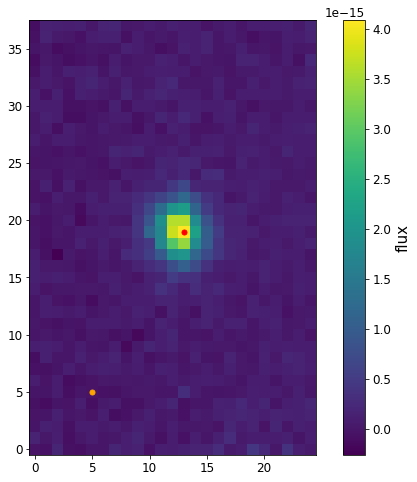

In [10]:
## this means "pixel" one is actually an image. Lets use imshow to look at this.

## plt imshow takes in 2D data and turns it into an image
plt.imshow(spectrum[0].data[0],origin='lower')
## add a colorbar to show the flux for each pixel (actual pixel in an image - I know this is confusing!)
plt.colorbar(label='flux')
## I'm going to label a single point inside the star for reference
plt.scatter(13,19,color='red')
## and then this single point corresponds to a part of the background (sky)
plt.scatter(5,5,color='orange')
## then display the plot
plt.show()

In [11]:
## now what we need to do is write a function that will extract the star
## this uses the same framework of aperture photometry (lets talk about this in our next meeting!)
## I've gone ahead and written this for you as I think data extraction is not something we should get super into

## always give your functions descriptive names!
## I'll note here that it is "bad" practice to use variable names in functions that also exist outside the function
## I will also note I don't follow my own advice
def extract_star_from_wifes(spectrum,threshold,mask_pixel=0,debugging_output=False):
    ## takes in a fits object called spectrum and a threshold which is a percentage (will need tweaking)
    ## also takes in a pixel number to create the mask on
    ## I also allow you to toggle on output in case you want to try debugging
    ## lets define some empty arrays to store our data in
    flux_data = []
    sky_data = []
    ## this one will be a "mask" on which pixels represent the star
    threshold_mask = np.full(np.shape(spectrum[0].data[0]),fill_value=False)
    
    ## lets create a threshold mask based on the first wavelength "pixel" to use
    ## we should keep in mind that the blue spectra will have low flux at small wavelengths
    ## I've allowed us to change the input value for the blue spectra
    for row in range(0,np.shape(spectrum[0])[1]):
        for column in range(0,np.shape(spectrum[0])[2]):
            ## this is the part we care about, it will turn to true if the value is greater
            ##     than our defined threshold
            if spectrum[0].data[mask_pixel][row,column] >= np.max(spectrum[0].data[mask_pixel])*threshold:
                threshold_mask[row,column] = True
    
    ## now that we have the mask,
    ## lets loop over each of the wavelength "pixels"
    for i in range(0,np.shape(spectrum[0])[0]):
        if debugging_output:
            print('pixel is',i)
        ## now for every "pixel" we'll be able to simply sum up all the data in the mask
        ## then we'll store that in the flux_data array we made
        flux_data.append(np.sum(spectrum[0].data[i][threshold_mask]))
        ## lets do something similar but take the median value of all the sky pixels
        median_sky = np.median(spectrum[0].data[i][~threshold_mask])
        ## then multiply that by the number of pixels the star takes up and store
        sky_data.append(median_sky*len(spectrum[0].data[i][threshold_mask]))
        if debugging_output:
            print(np.sum(spectrum[0].data[i][threshold_mask]))
            print(len(spectrum[0].data[i][threshold_mask]))
            print(np.median(spectrum[0].data[i][~threshold_mask]))
            print(np.median(spectrum[0].data[i][~threshold_mask])*len(spectrum[0].data[i][threshold_mask]))
            print(len(spectrum[0].data[i][~threshold_mask]))
            
    ## great, now lets convert our lists into numpy arrays so we can do math with them later
    flux_data = np.asarray(flux_data)
    sky_data = np.asarray(sky_data)
    
    ## tell the function to return the data
    return flux_data,sky_data

In [12]:
## now lets try it out
flux_data,sky_data = extract_star_from_wifes(spectrum,threshold=0.01)

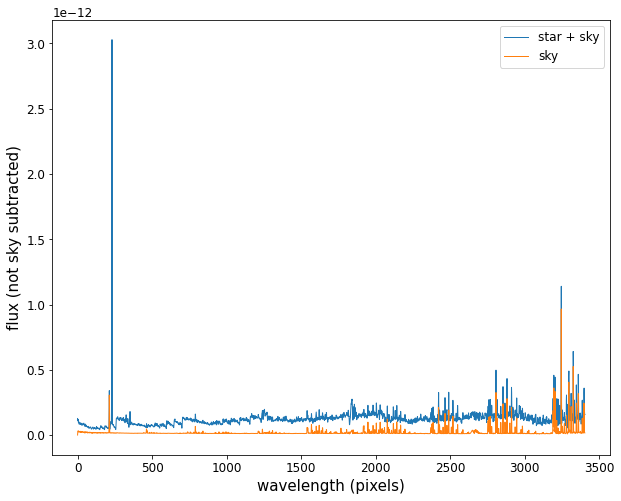

In [13]:
## plot the output and make sure it makes sense
plt.plot(flux_data,label='star + sky')
plt.plot(sky_data,label='sky')
plt.xlabel('wavelength (pixels)')
plt.ylabel('flux (not sky subtracted)')
plt.legend()
plt.show()

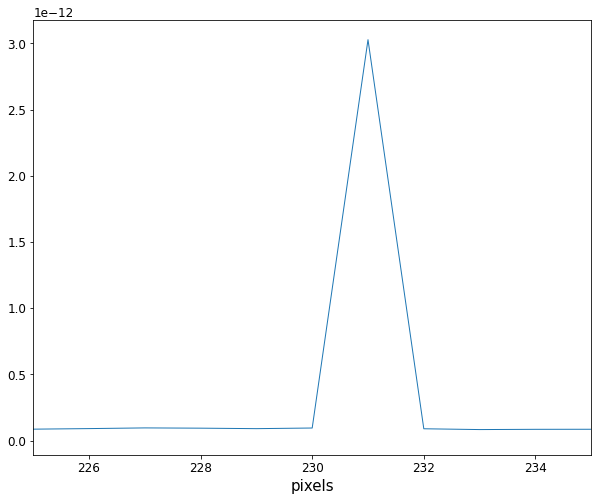

In [14]:
## we have a strong cosmic at pixel 231 but I'll let you handle taking care of that :)
plt.plot(flux_data,label='star + sky')
plt.xlim(225,235)
plt.xlabel('pixels')
plt.show()

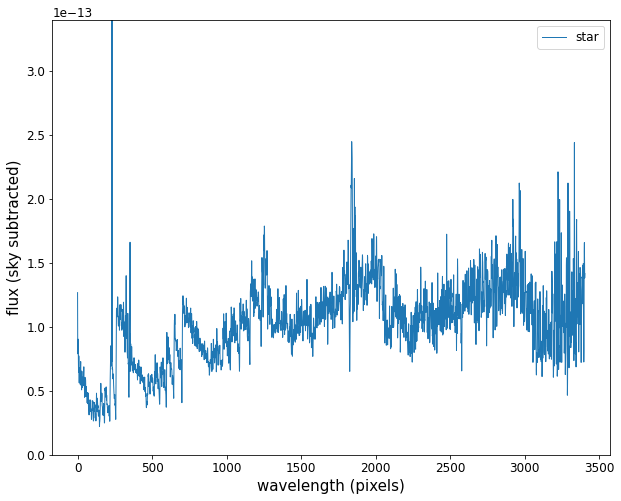

In [15]:
## so we simply subtract our sky spectrum from our aperture spectrum to get the stellar spectrum
plt.plot(flux_data-sky_data,label='star')
plt.xlabel('wavelength (pixels)')
plt.ylabel('flux (sky subtracted)')
plt.legend()

## I've cut off the top a bit since we have that nasty cosmic
plt.ylim(0, 3.4e-13)
plt.show()